# SDDP and newsvendor

## Classic SDDP

In [1]:
using Distributions, JuMP, Gurobi, Plots, ProgressMeter
gurobi_env = Gurobi.Env()

Academic license - for non-commercial use only - expires 2021-03-16


Gurobi.Env(Ptr{Nothing} @0x0000000002fc8180, false, 0)

In [2]:
function piecewise_linear(x,cuts)
    
    return maximum([cut[1]+cut[2]*x for cut in cuts])
end

piecewise_linear (generic function with 1 method)

In [3]:
p = 1.0 #day ahead price
q = 0.02 #same day price quadratic coefficient

#condicion inicial de stock
x0=0.0;

In [4]:
#array de vectores de cuts. Arranca en la lower bound
cuts = [[0.0;0.0]];

@showprogress for i=1:20
#for i=1:20
    #resuelvo el primer paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
    @variable(model,reserve>=0);
    @variable(model,stock>=0);
    @variable(model,z);

    for i=1:length(cuts)
        cut=cuts[i]
        @constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
    end

    fix_x = @constraint(model,stock==x0);

    @objective(model,Min,p*reserve+z);

    optimize!(model)

    x=value(stock)+value(reserve);

    #resuelvo para todos los ruidos el segundo paso y agrego un corte
    local_cuts = [];

    for demand=(0:1:100)
        

        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,shortage>=0);
        @variable(model,stock>=0);

        @constraint(model,stock-demand+shortage>=0);
        fix_x = @constraint(model,stock==x);
        
        @objective(model,Min,q*shortage^2);

        optimize!(model)

        beta = objective_value(model);
        lambda = dual(fix_x)
        push!(local_cuts,[beta-lambda*x;lambda])

    end

    new_cut = 1/length(local_cuts)*[sum([c[1] for c in local_cuts]);sum([c[2] for c in local_cuts])];
    push!(cuts,new_cut);
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


### Animación de los cortes

┌ Info: Saved animation to 
│   fn = /home/andres/workspace/julia/sddp/newsvendor/tmp.gif
└ @ Plots /home/andres/.julia/packages/Plots/KN96c/src/animation.jl:104


Plots.AnimatedGif("/home/andres/workspace/julia/sddp/newsvendor/tmp.gif")
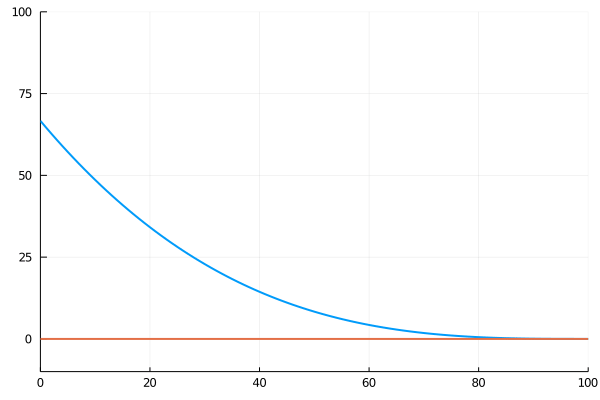

In [5]:
#Ploteo los cuts obtenidos
x=(0:100)

V(x) = q*(100-x)^3/(3*100)

anim=nothing
anim = @animate for i=1:length(cuts)
    pl=plot(;legend=:none,xlim=(0,100),ylim=(-10,100))
    plot!(pl,x,V.(x),lw=2)

#    cut=cuts[i]
#    plot!(pl,cut[1].+cut[2]*x);
    plot!(pl,x,piecewise_linear.(x,Ref(cuts[1:i])),lw=2)

end

gif(anim,"tmp.gif",fps=1)

### Resuelvo el problema de stock

In [6]:
#resuelvo una vez mas para hallar el costo optimo
model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))


@variable(model,reserve>=0);
@variable(model,stock>=0);
@variable(model,z);

for i=1:length(cuts)
    cut=cuts[i]
    @constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
end

fix_x = @constraint(model,stock==x0);

@objective(model,Min,p*reserve+z);

optimize!(model)

x=value(stock)+value(reserve);
costo = objective_value(model);
println("x: $x, Costo: $costo")


x: 29.434697242104704, Costo: 53.12326011336209


## Stochastic cutting plane

In [7]:
#array de vectores de cuts. Arranca en la lower bound
cuts = [[0.0;0.0]];

#aca guardo solo los multiplicadores
duals = [0.0];

#aca guardo los ruidos que fueron saliendo
noises = Array{Float64}(undef,0);

#condicion inicial de stock
x0=0.0;

In [8]:
#inicializo la animacion para ir viendo los cortes paso a paso
anim=Animation()

@showprogress 1 "Computing..." for l=1:200
    #resuelvo el primer paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(model,reserve>=0);
    @variable(model,stock>=0);
    @variable(model,z);

    for k=1:length(cuts)
        cut=cuts[k]
        @constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
    end

    fix_x = @constraint(model,stock==x0);

    @objective(model,Min,p*reserve+z);

    optimize!(model)

    x=value(stock)+value(reserve);

    #resuelvo para un ruido en el segundo paso y agrego un corte
    demand=rand(DiscreteUniform(1,100));

    push!(noises,demand)

    local_cuts = [];

    for k=1:length(noises)

        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,shortage>=0);
        @variable(model,stock>=0);

        fix_x = @constraint(model,x-noises[k]+shortage>=0);

        @objective(model,Min,q*shortage^2);

        optimize!(model)

        beta = objective_value(model);
        lambda = -dual(fix_x)

        push!(local_cuts,[beta-lambda*x;lambda])

    end


    #update all previous cuts for averaging
    for j=1:length(cuts)
        cuts[j] = (l-1)/l * cuts[j];
    end

    new_cut = 1/length(local_cuts)*[sum([c[1] for c in local_cuts]);sum([c[2] for c in local_cuts])];
    push!(cuts,new_cut);
    push!(duals,new_cut[2]);
    
    x=(0:100)
    pl=plot(;xlabel="Iteracion $l",legend=:none,xlim=(0,100),ylim=(-10,100))
    plot!(pl,x,V.(x),lw=2)
    plot!(pl,x,piecewise_linear.(x,Ref(cuts)),lw=2)

    frame(anim)

    #cuts = cuts[max(end-20,1):end]
end

Computing...100%|███████████████████████████████████████| Time: 0:00:19


### Animación de los cortes

┌ Info: Saved animation to 
│   fn = /home/andres/workspace/julia/sddp/newsvendor/tmp2.gif
└ @ Plots /home/andres/.julia/packages/Plots/KN96c/src/animation.jl:104


Plots.AnimatedGif("/home/andres/workspace/julia/sddp/newsvendor/tmp2.gif")
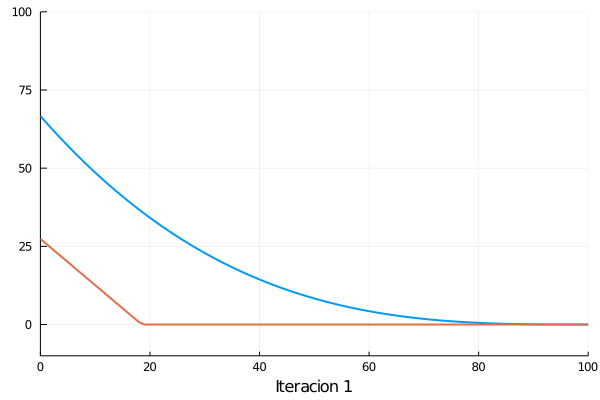

In [9]:
gif(anim,"tmp2.gif",fps=10)

### Resuelvo el problema de stock

In [10]:
#resuelvo una vez mas para hallar el costo optimo
model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env)))

@variable(model,reserve>=0);
@variable(model,stock>=0);
@variable(model,z);

for i=1:length(cuts)
    cut=cuts[i]
    @constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
end

fix_x = @constraint(model,stock==x0);

@objective(model,Min,p*reserve+z);

optimize!(model)

x=value(stock)+value(reserve);
costo = objective_value(model);
x

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 202 rows, 3 columns and 602 nonzeros
Model fingerprint: 0xa89b21e6
Coefficient statistics:
  Matrix range     [7e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+01]
Presolve removed 2 rows and 1 columns
Presolve time: 0.00s
Presolved: 200 rows, 2 columns, 400 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.416716e+03   0.000000e+00      0s
       4    5.2709004e+01   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.00 seconds
Optimal objective  5.270900421e+01

User-callback calls 33, time in user-callback 0.00 sec


27.149633251631705

## Stochastic Decomposition

In [17]:
#array de vectores de cuts. Arranca en la lower bound
cuts = [[0.0;0.0]];

#aca guardo solo los multiplicadores
duals = Set{Float64}();

#aca guardo los ruidos que fueron saliendo
noises = Array{Float64}(undef,0);

#condicion inicial de stock
x0=0.0;

In [18]:
anim=Animation()

#@showprogress 1 "Computing..." for l=1:200
for l=1:200
    
    #resuelvo el primer paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(model,reserve>=0);
    @variable(model,stock>=0);
    @variable(model,z);

    cut_constraints = [];
    for k=1:length(cuts)
        cut=cuts[k]
        c=@constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
        push!(cut_constraints,c);
    end

    fix_x = @constraint(model,stock==x0);

    @objective(model,Min,p*reserve+z);

    optimize!(model)

    #purge cuts!
    #multipliers = [dual(c) for c in cut_constraints];
    #idx = filter(k->multipliers[k]!=0,(1:length(cuts)));
    #cuts = cuts[idx];


    x=value(stock)+value(reserve);

    #resuelvo para un ruido en el segundo paso y agrego un corte
    demand=rand(DiscreteUniform(0,100));
    push!(noises,demand)


    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(model,shortage>=0);
    @variable(model,stock>=0);

    fix_x = @constraint(model,x-demand+shortage>=0);

#    fix_x = @constraint(model,stock==x);

    @objective(model,Min,q*shortage^2);

    optimize!(model)

    beta = objective_value(model);
    lambda = dual(fix_x)

    push!(duals,lambda)

    #update all previous cuts for averaging
    for j=1:length(cuts)
        cuts[j] = (l-1)/l * cuts[j];
    end

    pik = similar(noises);
    #genero el new cut recorriendo todos los ruidos
    for j=1:length(noises)
        aux = [(pi*(noises[j]-x),pi) for pi in duals]
        _, ix = findmax([a[1] for a in aux])
        pik[j] = aux[ix][2];
    end

    new_cut  = 1/l * [ sum(pik.*noises); -sum(pik) ];

    push!(cuts,new_cut);
    #println("Estado $x, \t noise: $demand \t corte: $new_cut, dual= $lambda")
    x=(0:100)
    pl=plot(;title="Iteracion $l",legend=:none,xlim=(0,100),ylim=(-10,100))
    plot!(pl,x,V.(x),lw=2)
    plot!(pl,x,piecewise_linear.(x,Ref(cuts)),lw=2)
    frame(anim)

end

### Animacion de los cortes

┌ Info: Saved animation to 
│   fn = /home/andres/workspace/julia/sddp/newsvendor/tmp3.gif
└ @ Plots /home/andres/.julia/packages/Plots/KN96c/src/animation.jl:104


Plots.AnimatedGif("/home/andres/workspace/julia/sddp/newsvendor/tmp3.gif")
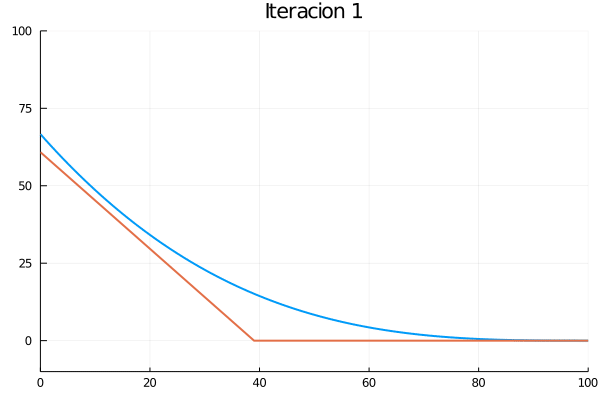

In [19]:
gif(anim,"tmp3.gif",fps=10)

### Resuelvo el problema de stock.

In [20]:
#resuelvo una vez mas para hallar el costo optimo
model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env)))

@variable(model,reserve>=0);
@variable(model,stock>=0);
@variable(model,z);

for i=1:length(cuts)
    cut=cuts[i]
    @constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
end

fix_x = @constraint(model,stock==x0);

@objective(model,Min,p*reserve+z);

optimize!(model)

x=value(stock)+value(reserve);
costo = objective_value(model);

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 202 rows, 3 columns and 600 nonzeros
Model fingerprint: 0x77d68a90
Coefficient statistics:
  Matrix range     [8e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 144 rows and 1 columns
Presolve time: 0.00s
Presolved: 58 rows, 2 columns, 116 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.669734e+03   0.000000e+00      0s
       4    8.7771714e+01   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.00 seconds
Optimal objective  8.777171429e+01

User-callback calls 36, time in user-callback 0.00 sec


In [21]:
x

77.57142857142873

## Stochastic Decomposition Enventanado

In [49]:
#array de vectores de cuts. Arranca en la lower bound
cuts = [[0.0;0.0]];

#aca guardo solo los multiplicadores
duals = Float64[]

#aca guardo los ruidos que fueron saliendo
noises = Array{Float64}(undef,0);
explored_states = similar(noises)

#condicion inicial de stock
x0=0.0;

ventana(x,x0,h) = max(1-abs(x-x0)/h,0)
h=5

5

In [50]:
anim=Animation()

#@showprogress 1 "Computing..." for l=1:200
for l=1:500
    
    #resuelvo el primer paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(model,reserve>=0);
    @variable(model,stock>=0);
    @variable(model,z);

    cut_constraints = [];
    for k=1:length(cuts)
        cut=cuts[k]
        c=@constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
        push!(cut_constraints,c);
    end

    fix_x = @constraint(model,stock==x0);

    @objective(model,Min,p*reserve+z);

    optimize!(model)

    #purge cuts!
    #multipliers = [dual(c) for c in cut_constraints];
    #idx = filter(k->multipliers[k]!=0,(1:length(cuts)));
    #cuts = cuts[idx];


    x=value(stock)+value(reserve);

    #resuelvo para un ruido en el segundo paso y agrego un corte
    demand=rand(DiscreteUniform(0,100));
    push!(noises,demand)
    push!(explored_states,x)

    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(model,shortage>=0);
    @variable(model,stock>=0);

    fix_x = @constraint(model,x-demand+shortage>=0);

#    fix_x = @constraint(model,stock==x);

    @objective(model,Min,q*shortage^2);

    optimize!(model)

    beta = objective_value(model);
    lambda = dual(fix_x)

    push!(duals,lambda)

    #update all previous cuts for averaging
    for j=1:length(cuts)
        cuts[j] = (l-1)/l * cuts[j];
    end

    pik = similar(noises);
    #genero el new cut recorriendo todos los ruidos
    for j=1:length(noises)
        aux = [(duals[k]*ventana(x,explored_states[k],h)*(noises[j]-x),duals[k]*ventana(x,explored_states[k],h)) for k in 1:length(noises)]
        _, ix = findmax([a[1] for a in aux])
        pik[j] = aux[ix][2];
    end

    new_cut  = 1/l * [ sum(pik.*noises); -sum(pik) ];

    push!(cuts,new_cut);
    #println("Estado $x, \t noise: $demand \t corte: $new_cut, dual= $lambda")
    x=(0:100)
    pl=plot(;title="Iteracion $l",legend=:none,xlim=(0,100),ylim=(-10,100))
    plot!(pl,x,V.(x),lw=2)
    plot!(pl,x,piecewise_linear.(x,Ref(cuts)),lw=2)
    frame(anim)

end

### Animacion de los cortes

┌ Info: Saved animation to 
│   fn = /home/andres/workspace/julia/sddp/newsvendor/tmp3.gif
└ @ Plots /home/andres/.julia/packages/Plots/KN96c/src/animation.jl:104


Plots.AnimatedGif("/home/andres/workspace/julia/sddp/newsvendor/tmp3.gif")
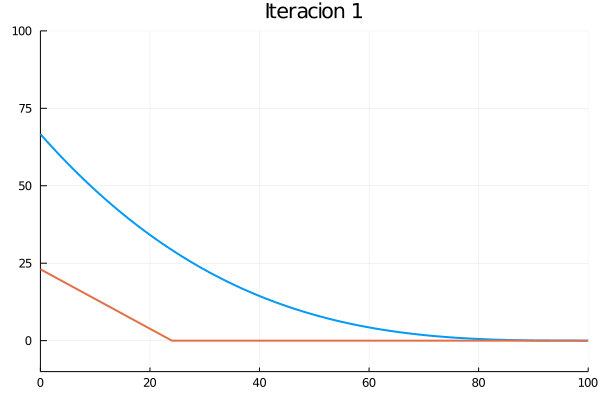

In [51]:
gif(anim,"tmp3.gif",fps=10)

### Resuelvo el problema de stock.

In [52]:
#resuelvo una vez mas para hallar el costo optimo
model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env)))

@variable(model,reserve>=0);
@variable(model,stock>=0);
@variable(model,z);

for i=1:length(cuts)
    cut=cuts[i]
    @constraint(model,z>=cut[1]+cut[2]*(stock+reserve));
end

fix_x = @constraint(model,stock==x0);

@objective(model,Min,p*reserve+z);

optimize!(model)

x=value(stock)+value(reserve);
costo = objective_value(model);

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 502 rows, 3 columns and 1482 nonzeros
Model fingerprint: 0xa8a2fc7e
Coefficient statistics:
  Matrix range     [2e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 8e+01]
Presolve removed 247 rows and 1 columns
Presolve time: 0.00s
Presolved: 255 rows, 2 columns, 510 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.335352e+03   0.000000e+00      0s
       3    7.3042818e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.00 seconds
Optimal objective  7.304281823e+01

User-callback calls 35, time in user-callback 0.00 sec


In [53]:
x

53.830347204449964